In [4]:
import os, pickle, warnings
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np

# modeling/experimentation
import mlflow
from scipy import interpolate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# to load parameters of the experiments
from kedro.config import ConfigLoader

# utils
from joblib import Parallel, delayed
from pandas import IndexSlice as idx
from IPython.display import display

# viz
import seaborn as sns
import matplotlib.pyplot as plt

# experiments
from experiments.configs.evaluation import eval_sets
from experiments.noaa.deterministic import NOAADeterministicExperiment
from spatial_interpolation.visualization import map_viz
# print("Available experiment configs:",NOAADeterministicExperiment.config.config.keys())

# local utils and other imports
from spatial_interpolation.interpolators import ScipyInterpolator
from spatial_interpolation import data, utils
from spatial_interpolation.utils.experiments import conf 
from spatial_interpolation.data.load_data import get_ml_workspace
from spatial_interpolation.utils import tqdm_joblib
from spatial_interpolation.visualization import plot_interpolation, map_viz


# notebook configuration
import dotenv
warnings.simplefilter(action='ignore', category=FutureWarning)
dotenv.load_dotenv()

True

In [7]:
# load data
experiment = NOAADeterministicExperiment("linear_set3", n_jobs=1)
config = experiment.get_config()
dataset = data.NDBCDataLoader(**config.data_loading).load()
df, gdf = dataset.buoys_data, dataset.buoys_geo
locations_within_area = gdf.loc[gdf.within(eval_sets.ndbc[config.eval_set].area)].index.get_level_values("buoy_id").unique()
df = df.loc[df.index.get_level_values("buoy_id").isin(locations_within_area)]
gdf = gdf.loc[idx[:, locations_within_area],:]
dataset = data.NDBCData(df, gdf)

train, test = dataset.split_slice(test=eval_sets.ndbc[config.eval_set].eval)
train_df = train.join()
test_df = test.join()

target = config.target
train_by_times = (
    train_df
    .reset_index()
    .rename(columns={"buoy_id": "location_id"})
    .set_index(["time", "location_id"])
    .sort_index()
    .dropna(subset=[target])
)
test_by_times = (
    test_df
    .reset_index()
    .rename(columns={"buoy_id": "location_id"})
    .set_index(["time", "location_id"])
    .sort_index()
    .dropna(subset=[target])
)


Split test obtained with dataset(s)=['buoys_data'] and shape(s)=[(116092, 14)]


In [6]:
time = pd.Timestamp(
    "2020-05-10 05:00"
 )

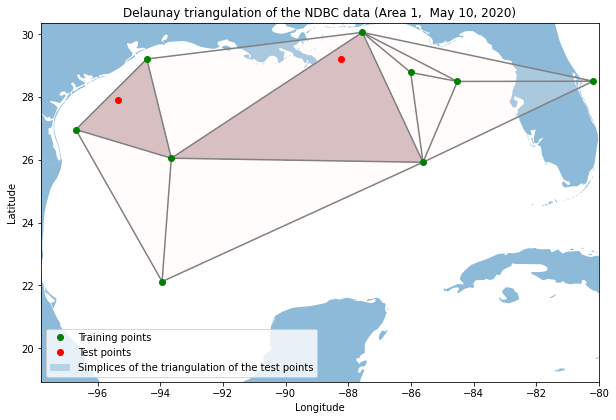

In [13]:
from scipy.spatial import Delaunay

dims = ["longitude","latitude"]
points = train_by_times.loc[time,dims].values
tri = Delaunay(points, incremental=True)
# plot the triangulation
fig,ax = plt.subplots(1,1,figsize=(10,10))
df_countries = data.load_world_borders()
df_countries.plot(ax=ax,alpha=0.5)
xmin, ymin, xmax, ymax = eval_sets.ndbc[config.eval_set].area.bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
ax.plot(points[:,0], points[:,1], 'o', color="green",label="Training points")
ax.set(xlabel="Longitude",ylabel="Latitude",title=f"Delaunay triangulation of the NDBC data (Area {config.eval_set[-1]}, {time: %b %d, %Y})")
ax.triplot(points[:,0], points[:,1], tri.simplices.copy(), color="grey")
test_points = test_by_times.loc[time,dims].values
ax.plot(test_points[:,0], test_points[:,1], 'o', color="red", label="Test points")
ind_tri = tri.find_simplex(test_points)
tri_mask = np.zeros(len(tri.simplices))
tri_mask[ind_tri] = 1
ax.tripcolor(
    points[:,0], points[:,1], tri.simplices.copy(), tri_mask, cmap="Reds", alpha=0.25, 
    label="Simplices of the triangulation of the test points")
closest_points = points[tri.simplices[ind_tri]][0]
ax.legend()

No handles with labels found to put in legend.


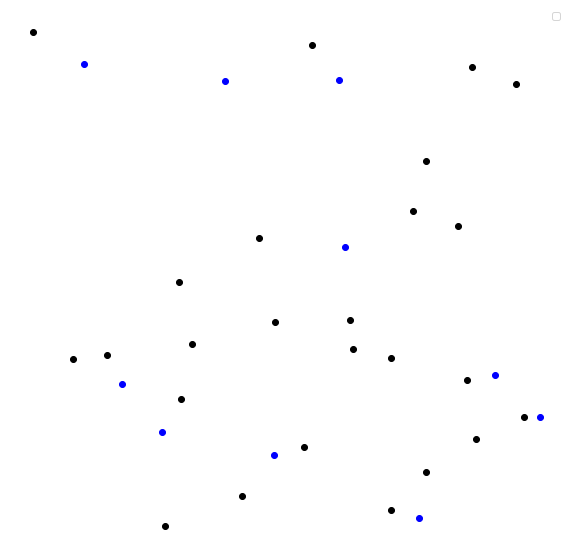

In [217]:
rand_points_X = np.random.uniform(xmin, xmax, size=(25,))
rand_points_Y = np.random.uniform(ymin, ymax, size=(25,))
rand_points = np.vstack([rand_points_X, rand_points_Y]).T
rand_points_new_X = np.random.uniform(xmin, xmax, size=(10,))
rand_points_new_Y = np.random.uniform(ymin, ymax, size=(10,))
rand_points_new = np.vstack([rand_points_new_X, rand_points_new_Y]).T
tri = Delaunay(rand_points, incremental=True)
ind_tri = tri.find_simplex(rand_points_new)
# plot the triangulation
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(rand_points[:,0], rand_points[:,1], 'o', color="black") # training points
ax.plot(rand_points_new[:,0], rand_points_new[:,1], 'o', color="blue") # test points 
# ax.triplot(rand_points[:,0], rand_points[:,1], tri.simplices.copy(), color="black")
tri_mask = np.zeros(len(tri.simplices))
tri_mask[ind_tri] = 1
# ax.tripcolor(
#     rand_points[:,0], rand_points[:,1], tri.simplices.copy(), tri_mask, 
#     cmap="Reds", alpha=0.25
# ) 
closest_points = rand_points[tri.simplices[ind_tri]].reshape(-1,2)
ax.legend()
# ax.plot(closest_points[:,0], closest_points[:,1], 'o', color="red")
ax.axis('off');

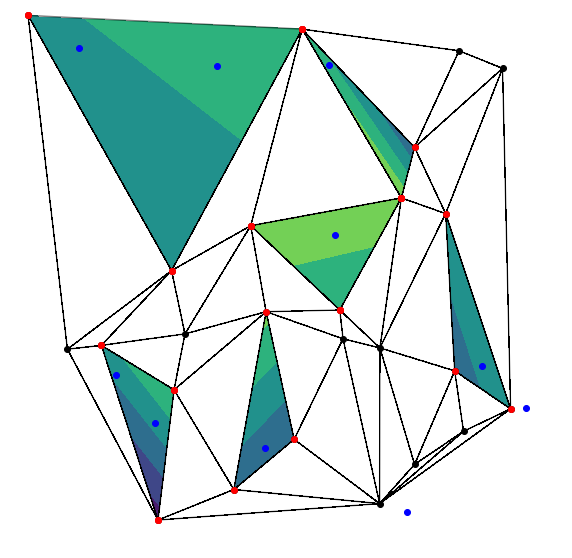

In [223]:
import matplotlib as mpl
# assign random values to each point
rand_values = np.random.uniform(0, 1, size=(len(rand_points),))
# interpolate
f = interpolate.LinearNDInterpolator(rand_points, rand_values)
# interpolate a grid
grid_x, grid_y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
z = f(grid_x.ravel(), grid_y.ravel())
grid_z = z.reshape(grid_x.shape)
# plot the interpolation
fig,ax = plt.subplots(1,1,figsize=(10,10))
tri_mask = np.ones(len(tri.simplices)).astype(bool)
tri_mask[ind_tri] = 0
CS = ax.contourf(grid_x, grid_y, grid_z, cmap="viridis")
ax.scatter(rand_points_new[:,0], rand_points_new[:,1], marker='o', color="blue") # test points
ax.triplot(rand_points[:,0], rand_points[:,1], tri.simplices.copy(), color="black", alpha=0.5)
ax.tripcolor(
    rand_points[:,0], rand_points[:,1], tri.simplices[tri_mask], np.ones(len(tri.simplices[tri_mask])), 
    cmap=mpl.colors.ListedColormap("white"), color="black",
)
ax.scatter(rand_points[:,0], rand_points[:,1],color="black", marker='o',zorder=10)
ax.scatter(closest_points[:,0], closest_points[:,1],color="red", marker='o',zorder=11)
ax.axis('off');

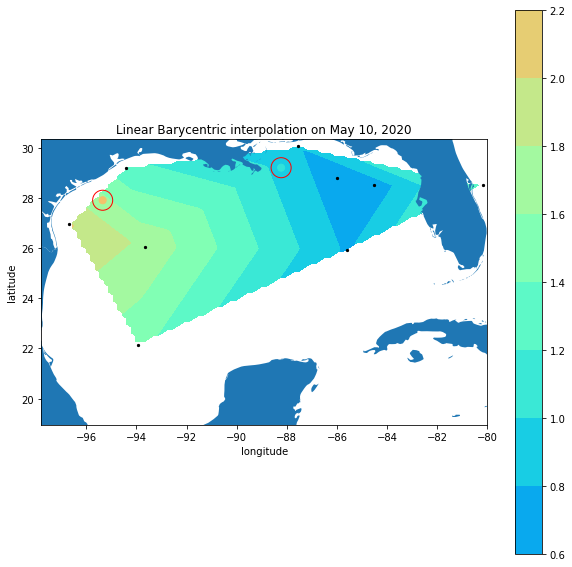

In [15]:
linear_interpolator = ScipyInterpolator(
    interpolate.LinearNDInterpolator,
    dimensions=[dims],
)
time = pd.Timestamp("2020-05-10 05:00")
linear_interpolator.fit(train_by_times.loc[time],y=target)
cm = plot_interpolation(
    train_by_times.loc[time].x,train_by_times.loc[time].y,
    test_by_times.loc[time].x,test_by_times.loc[time].y,
    test_by_times.loc[time][target],
    interpolator=linear_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    title=f"Linear Barycentric interpolation on {time:%b %-d, %Y}",
    cmap="rainbow",
    zmin=0,zmax=3
)

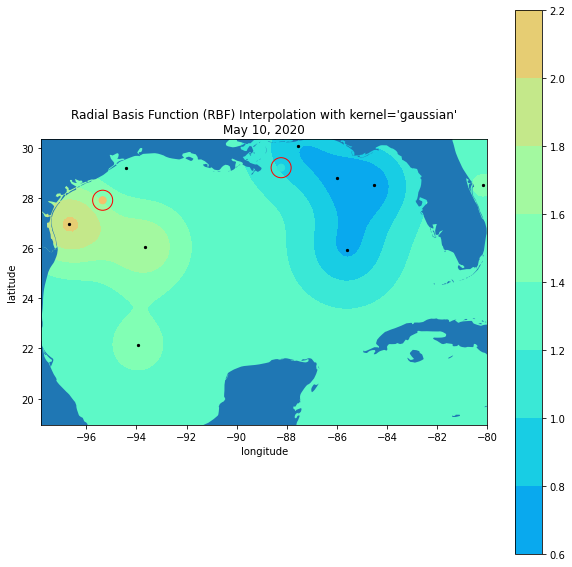

In [40]:
kernel = "gaussian"
rbf_interpolator = ScipyInterpolator(
    interpolate.RBFInterpolator,
    dimensions=[dims],
    kernel=kernel,
    epsilon=.6
)
rbf_interpolator.fit(train_by_times.loc[time],y=target)
plot_interpolation(
    train_by_times.loc[time].x,train_by_times.loc[time].y,
    test_by_times.loc[time].x,test_by_times.loc[time].y,
    test_by_times.loc[time][target],
    rbf_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    cmap=cm.cmap,
    zmin=0,zmax=3,
    title=f"Radial Basis Function (RBF) Interpolation with {kernel=}\n{time:%b %-d, %Y}",
)

In [2]:
pred_dfs = []
train_times = train_by_times.index.get_level_values("time").unique()
# interpolator = ScipyInterpolator(
#     interpolate.RBFInterpolator,
#     dimensions=[dims],
#     kernel=kernel,
#     epsilon=0.3
# )
interpolator = ScipyInterpolator(
    interpolate.LinearNDInterpolator,
    dimensions=[dims],
)
for t in tqdm(test_by_times.index.get_level_values("time").unique().to_series().sample(frac=0.05)):
    if t not in train_times:
        continue
    interpolator.fit(train_by_times.loc[t],y=target)
    pred = interpolator.predict(test_by_times.loc[t])
    pred_df = pd.DataFrame({target:pred},index=test_by_times.loc[[t]].index)
    pred_dfs.append(pred_df)
pred_df = pd.concat(pred_dfs).join(test_by_times[[target]], rsuffix="_true")

NameError: name 'train_by_times' is not defined

In [27]:
true = pred_df.dropna()[target+"_true"]
pred = pred_df.dropna()[target]
print(
    f'r2: {r2_score(true,pred):.4f}',
    f'mae: {mean_absolute_error(true,pred):.4f}',
    f'rmse: {mean_squared_error(true,pred, squared=False):.4f}',
)


r2: 0.7441 mae: 0.2045 rmse: 0.3277


In [8]:
from experiments.noaa.deterministic import NOAADeterministicExperiment
from experiments.configs.evaluation import eval_sets as eval_conf
from spatial_interpolation.visualization import map_viz
import subprocess
available_configs = NOAADeterministicExperiment.config.config.keys()
print("Available experiment configs:",available_configs)
print("Number of available configs:",len(available_configs))
# experiment.run()

Available experiment configs: ['idw_set1', 'idw_set2', 'idw_set3', 'linear_set1', 'linear_set2', 'linear_set3', 'rbf_cubic_set1', 'rbf_cubic_set2', 'rbf_cubic_set3', 'rbf_gaussian_eps_0_05_set1', 'rbf_gaussian_eps_0_05_set2', 'rbf_gaussian_eps_0_05_set3', 'rbf_gaussian_eps_0_1_set1', 'rbf_gaussian_eps_0_1_set2', 'rbf_gaussian_eps_0_1_set3', 'rbf_gaussian_eps_0_5_set1', 'rbf_gaussian_eps_0_5_set2', 'rbf_gaussian_eps_0_5_set3', 'rbf_gaussian_eps_1_set1', 'rbf_gaussian_eps_1_set2', 'rbf_gaussian_eps_1_set3', 'rbf_inverse_multiquadric_eps_0_05_set1', 'rbf_inverse_multiquadric_eps_0_05_set2', 'rbf_inverse_multiquadric_eps_0_05_set3', 'rbf_inverse_multiquadric_eps_0_5_set1', 'rbf_inverse_multiquadric_eps_0_5_set2', 'rbf_inverse_multiquadric_eps_0_5_set3', 'rbf_inverse_multiquadric_eps_1_set1', 'rbf_inverse_multiquadric_eps_1_set2', 'rbf_inverse_multiquadric_eps_1_set3', 'rbf_inverse_multiquadric_eps_2_set1', 'rbf_inverse_multiquadric_eps_2_set2', 'rbf_inverse_multiquadric_eps_2_set3', 'rbf_m

In [61]:
for config_name in available_configs:
    # if "set3" in config_name and "eps" in config_name:
    if "rbf" in config_name:
        continue
    experiment_name = NOAADeterministicExperiment.__name__
    eval_frac = "0.3" if "set1" in config_name else "0.1"
    p = subprocess.Popen(["python", "-m", "experiments", experiment_name , config_name, f"--eval_frac={eval_frac}"])
    print(f"Started experiment {config_name} on process {p.pid}")

Started experiment cubic_set1 on process 11929
Started experiment cubic_set2 on process 11931
Started experiment cubic_set3 on process 11934
Started experiment idw_set1 on process 11936
Started experiment idw_set2 on process 12017
Started experiment idw_set3 on process 12020
Started experiment linear_set1 on process 12100
Started experiment linear_set2 on process 12146
Started experiment linear_set3 on process 12191
Started experiment thin_plate_spline_set1 on process 12200
Started experiment thin_plate_spline_set2 on process 12286
Started experiment thin_plate_spline_set3 on process 12330


Attempting to run experiment NOAADeterministicExperiment with config idw_set1...
Running experiment NOAADeterministicExperiment with experiment_config='idw_set1' and params: {'eval_frac': 0.1}
Attempting to run experiment NOAADeterministicExperiment with config thin_plate_spline_set2...
Running experiment NOAADeterministicExperiment with experiment_config='thin_plate_spline_set2' and params: {'eval_frac': 0.1}
Attempting to run experiment NOAADeterministicExperiment with config idw_set3...
Running experiment NOAADeterministicExperiment with experiment_config='idw_set3' and params: {'eval_frac': 0.1}
Attempting to run experiment NOAADeterministicExperiment with config linear_set1...
Running experiment NOAADeterministicExperiment with experiment_config='linear_set1' and params: {'eval_frac': 0.1}
Attempting to run experiment NOAADeterministicExperiment with config idw_set2...
Running experiment NOAADeterministicExperiment with experiment_config='idw_set2' and params: {'eval_frac': 0.1}
A

INFO:NOAADeterministicExperiment:Filtering data on area POLYGON ((-80 18.930645, -97.806644 18.930645, -97.806644 30.366655, -82.836914 30.366655, -82.836914 35.55, -68.115234 35.55, -68.115234 25.799891, -80 25.799891, -80 18.930645))
INFO:NOAADeterministicExperiment:Filtered data has shapes (1760006, 14) and (232, 4)
INFO:NOAADeterministicExperiment:Filtering data on area POLYGON ((-80 18.930645, -97.806644 18.930645, -97.806644 30.366655, -82.836914 30.366655, -82.836914 35.55, -68.115234 35.55, -68.115234 25.799891, -80 25.799891, -80 18.930645))
INFO:NOAADeterministicExperiment:Filtering data on area POLYGON ((-45 12.282308, -45 35.55, -98.251934 35.55, -98.251934 12.282308, -45 12.282308))
INFO:NOAADeterministicExperiment:Filtering data on area POLYGON ((-80 18.930645, -80 30.366655, -97.806644 30.366655, -97.806644 18.930645, -80 18.930645))
INFO:NOAADeterministicExperiment:Filtered data has shapes (1061321, 14) and (137, 4)
INFO:NOAADeterministicExperiment:Filtered data has sha

In [7]:
experiment = NOAADeterministicExperiment("linear_set4", n_jobs=1)
config = experiment.get_config()
dataset = data.NDBCDataLoader(**config.data_loading).load()
df, gdf = dataset.buoys_data, dataset.buoys_geo
locations_within_area = gdf.loc[gdf.within(eval_conf.ndbc[config.eval_set].area)].index.get_level_values("buoy_id").unique()
df = df.loc[df.index.get_level_values("buoy_id").isin(locations_within_area)]
gdf = gdf.loc[idx[:, locations_within_area],:]
dataset = data.NDBCData(df, gdf)

train, test = dataset.split_slice(test=eval_conf.ndbc[config.eval_set].eval)

Split test obtained with dataset(s)=['buoys_data'] and shape(s)=[(80437, 14)]


In [59]:
# train_df = train.buoys_data.join(train
#     .buoys_geo
#     .sort_index()
#     .reset_index()
#     .drop_duplicates("buoy_id",keep="last")
#     .drop(columns=["year"]) 
#     .set_index("buoy_id")
# ).dropna(subset=[target])
# test_df = test.buoys_data.join(test
#     .buoys_geo
#     .sort_index()
#     .reset_index()
#     .drop_duplicates("buoy_id",keep="last")
#     .drop(columns=["year"])
#     .set_index("buoy_id")
# ).dropna(subset=[target])

# train_by_times = train_df.swaplevel(0,1).sort_index()
# test_by_times = test_df.swaplevel(0,1).sort_index()

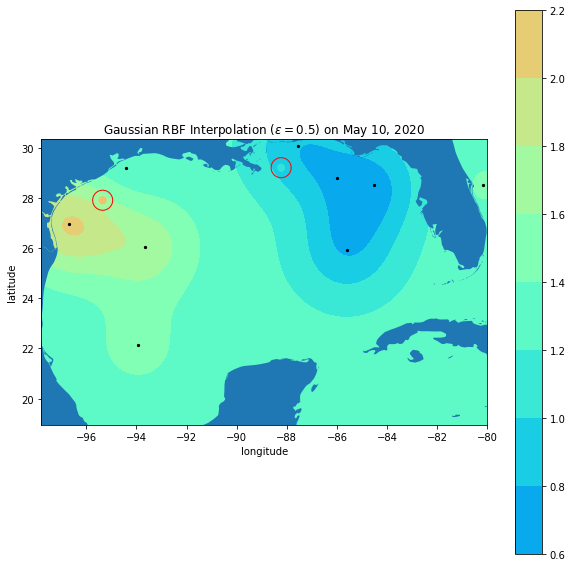

In [58]:
kernel = "gaussian"
time = pd.Timestamp(time)
epsilon=0.5
rbf_interpolator = ScipyInterpolator(
    interpolate.RBFInterpolator,
    dimensions=[["longitude","latitude"]],
    kernel=kernel,
    epsilon=epsilon
)
rbf_interpolator.fit(train_by_times.loc[time],y=target)
plot_interpolation(
    train_by_times.loc[time,rbf_interpolator.dim_cols[0]], train_by_times.loc[time,rbf_interpolator.dim_cols[1]],
    test_by_times.loc[time, rbf_interpolator.dim_cols[0]], test_by_times.loc[time, rbf_interpolator.dim_cols[1]],
    test_by_times.loc[time][target],
    rbf_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    cmap="rainbow",
    zmin=0,zmax=3,
    title=f"{kernel.capitalize()} RBF Interpolation ($\{epsilon=}$) on {time:%b %-d, %Y}",
)

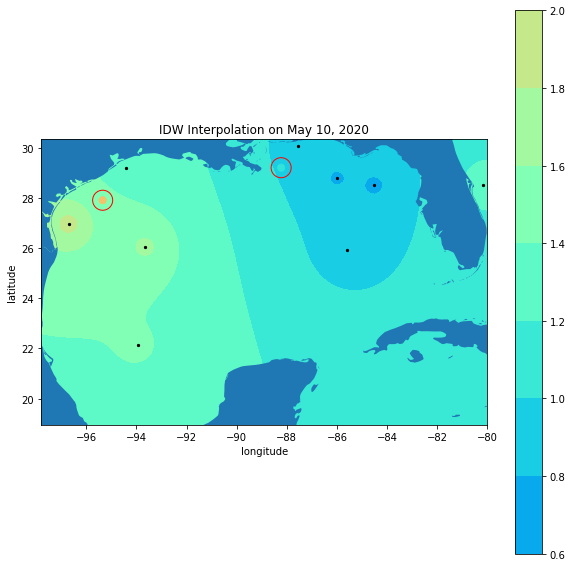

In [52]:
from spatial_interpolation.interpolators import IDWInterpolator
time = pd.Timestamp(time)
rbf_interpolator = ScipyInterpolator(
    IDWInterpolator,
    dimensions=[["longitude","latitude"]],
)
rbf_interpolator.fit(train_by_times.loc[time],y=target)
plot_interpolation(
    train_by_times.loc[time,rbf_interpolator.dim_cols[0]], train_by_times.loc[time,rbf_interpolator.dim_cols[1]],
    test_by_times.loc[time, rbf_interpolator.dim_cols[0]], test_by_times.loc[time, rbf_interpolator.dim_cols[1]],
    test_by_times.loc[time][target],
    rbf_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    cmap="rainbow",
    zmin=0,zmax=3,
    title=f"IDW Interpolation on {time:%b %-d, %Y}",
)

In [41]:
interpolator = IDWInterpolator(train_by_times.loc[time,config.dimensions[0]].values, train_by_times.loc[time,target].values)
interpolator(test_by_times.loc[time,config.dimensions[0]].values)

array([1.47018555, 0.97232586])